In order to build an agentic application, we need to give it access to possible courses of action so that it can make a decision given some context about the current state or some desired next state.

### Building a LangGraph agent

In [1]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be mathematical expression."""
    return ast.literal_eval(query)

In [3]:
search = DuckDuckGoSearchRun()
tools = [search, calculator]
model = ChatOpenAI(temperature=0.1).bind_tools(tools)

In [4]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

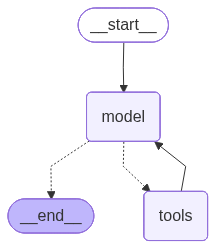

In [5]:
builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()
graph

In [6]:
input = {
 "messages": [
 HumanMessage("""How old was the 30th president of the United States when he died?""")
 ]
}

for c in graph.stream(input):
 print(c)

{'model': {'messages': AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 117, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Co5tf2rUwQPYhVdjp8pyKsokUthPX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--379c10c6-7d78-4526-810c-49c895da8561-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': '30th president of the United States age at death'}, 'id': 'call_Owb4AL0XDvWGe99qUuyVbUtE', 'type': 'tool_call'}], usage_metadata={'input_tokens': 117, 'output_tokens': 26, 'total_tokens': 143, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio

In this type of architecture we can see that the model call was the first to be made to decide which tool to be called next. But here we know that the search tool should be called first and it's input fed to the model. Let's try to do that now.

In [7]:
from langchain_core.messages import AIMessage, ToolCall
from uuid import uuid4

def first_model(state: State) -> State:
    query = state['messages'][-1].content
    search_tool_call = ToolCall(
        name="ddg_search", args={"query": query}, id=uuid4().hex
    )
    return {
        "messages": AIMessage(content="", tool_calls=[search_tool_call])
    }

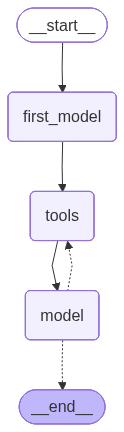

In [8]:
builder = StateGraph(State)
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")
graph = builder.compile()
graph

In [10]:
input = {
 "messages": [
 HumanMessage("""How old was the 30th president of the United States when he died?""")
 ]}

for c in graph.stream(input):
    print(c)

{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='92623213-3c5f-4177-a3b4-66e781fa861e', tool_calls=[{'name': 'ddg_search', 'args': {'query': 'How old was the 30th president of the United States when he died?'}, 'id': '5fc83c1159514b04a4449c499fef2f8b', 'type': 'tool_call'}])}}
{'tools': {'messages': [ToolMessage(content='Error: ddg_search is not a valid tool, try one of [duckduckgo_search, calculator].', name='ddg_search', id='0f4edd58-8211-4e91-88f3-83e6c0d09dde', tool_call_id='5fc83c1159514b04a4449c499fef2f8b', status='error')]}}
{'model': {'messages': AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 178, 'total_tokens': 210, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'op

Notice in the first_model we're passing the same kind of AIMessage that was produced earlier (content=""...), here was explicitely told the graph to use the search tool bypassing the LLM, this reduces the chance of hallucinations, is faster and cheaper and the response is more accurate (he was indeed 60 years old when he died not 61.)